### Load the data fom customers, orders, order_reviews and order_pymnts (other tables are not used in this notebook)

In [28]:
import pandas as pd
import sqlite3
import os

# Relative path to the database
db_path = os.path.join('..', 'data', 'olist.db')
conn = sqlite3.connect(db_path)

# Load the tables into DataFrames
customers = pd.read_sql_query("SELECT * FROM customers", conn)
orders = pd.read_sql_query("SELECT * FROM orders", conn)
order_reviews = pd.read_sql_query("SELECT * FROM order_reviews", conn)
order_pymts = pd.read_sql_query("SELECT * FROM order_pymts", conn)


conn.close()

print("Data loaded successfully.")


Data loaded successfully.


### Merge the data from the different tables

In [29]:
# Merge the orders and customers tables
orders_customers = pd.merge(orders, customers, on='customer_id', how='inner', suffixes=('_order', '_customer'))

# Aggregate reviews by order_id
order_reviews_agg = order_reviews.groupby('order_id').agg({
    'review_score': 'mean',
    'review_id': 'count'
}).rename(columns={'review_score': 'avg_review_score', 'review_id': 'review_count'}).reset_index()

# Aggregate payments by order_id
order_pymts_agg = order_pymts.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_sequential': 'count'
}).rename(columns={'payment_value': 'total_payment_value', 'payment_sequential': 'payment_count'}).reset_index()

# Merge the aggregated reviews with orders_customers
orders_customers_reviews = pd.merge(orders_customers, order_reviews_agg, on='order_id', how='left')

# Merge the aggregated payments with orders_customers_reviews
df_final = pd.merge(orders_customers_reviews, order_pymts_agg, on='order_id', how='left')

# Perform a control on the number of rows before and after merge
initial_row_count = len(orders)
final_row_count = len(df_final)
print(f"Initial row count in orders table: {initial_row_count}")
print(f"Final row count in df_final: {final_row_count}")

# Drop the customer_id column to avoid confusion
df_final.drop(columns=['customer_id'], inplace=True)

# Use only 'customer_unique_id' to identify each customer
df_final = df_final[['customer_unique_id'] + [col for col in df_final.columns if col != 'customer_unique_id']]

print("Tables merged successfully, data aggregated, and 'customer_id' column removed.")
df_final.head()


Initial row count in orders table: 99441
Final row count in df_final: 99441
Tables merged successfully, data aggregated, and 'customer_id' column removed.


,customer_unique_id,index_order,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customer,customer_zip_code_prefix,customer_city,customer_state,avg_review_score,review_count,total_payment_value,payment_count
0,7c396fd4830fd04220f754e42b4e5bff,0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,70296,3149,sao paulo,SP,4.0,1.0,38.71,3.0
1,af07308b275d755c9edb36a90c618231,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,77027,47813,barreiras,BA,4.0,1.0,141.46,1.0
2,3a653a41f6f9fc3d2a113cf8398680e8,2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,554,75265,vianopolis,GO,5.0,1.0,179.12,1.0
3,7c142cf63193a1473d2e66489a9ae977,3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,61081,59296,sao goncalo do amarante,RN,5.0,1.0,72.20,1.0
4,72632f0f9dd73dfee390c9b22eb56dd6,4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,67263,9195,santo andre,SP,5.0,1.0,28.62,1.0


### Save the Final DataFrame to a CSV File

In [30]:
# Ensure the data directory exists
output_dir = os.path.join('..', 'data')
os.makedirs(output_dir, exist_ok=True)

# Save the final DataFrame to a CSV file in the data directory
output_path = os.path.join(output_dir, 'df_final.csv')
df_final.to_csv(output_path, index=False)
print(f"df_final saved to {output_path}")


df_final saved to ..\data\df_final.csv


### Step 1: Exploratory Data Analysis (EDA)

#### First, we will conduct exploratory data analysis to understand the dataset better. This includes summarizing the data, checking for missing values, and visualizing distributions.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the final DataFrame
df_final_path = os.path.join('..', 'data', 'df_final.csv')
df_final = pd.read_csv(df_final_path)

# Display the first few rows
print("First few rows of the DataFrame:")
print(df_final.head())


# Summary statistics
print("Summary statistics:")
print(df_final.describe())


# Check for missing values
missing_values = df_final.isnull().sum()
missing_values_with_data = missing_values[missing_values > 0]

if not missing_values_with_data.empty:
    print("Columns with missing values and their respective counts:")
    print(missing_values_with_data)
else:
    print("No missing values found in the DataFrame.")


First few rows of the DataFrame:
                 customer_unique_id  index_order  \
0  7c396fd4830fd04220f754e42b4e5bff            0   
1  af07308b275d755c9edb36a90c618231            1   
2  3a653a41f6f9fc3d2a113cf8398680e8            2   
3  7c142cf63193a1473d2e66489a9ae977            3   
4  72632f0f9dd73dfee390c9b22eb56dd6            4   

                           order_id order_status order_purchase_timestamp  \
0  e481f51cbdc54678b7cc49136f2d6af7    delivered      2017-10-02 10:56:33   
1  53cdb2fc8bc7dce0b6741e2150273451    delivered      2018-07-24 20:41:37   
2  47770eb9100c2d0c44946d9cf07ec65d    delivered      2018-08-08 08:38:49   
3  949d5b44dbf5de918fe9c16f97b45f8a    delivered      2017-11-18 19:28:06   
4  ad21c59c0840e6cb83a9ceb5573f8159    delivered      2018-02-13 21:18:39   

     order_approved_at order_delivered_carrier_date  \
0  2017-10-02 11:07:15          2017-10-04 19:55:00   
1  2018-07-26 03:24:27          2018-07-26 14:31:00   
2  2018-08-08 08:55:23    

In [32]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_unique_id             99441 non-null  object 
 1   index_order                    99441 non-null  int64  
 2   order_id                       99441 non-null  object 
 3   order_status                   99441 non-null  object 
 4   order_purchase_timestamp       99441 non-null  object 
 5   order_approved_at              99281 non-null  object 
 6   order_delivered_carrier_date   97658 non-null  object 
 7   order_delivered_customer_date  96476 non-null  object 
 8   order_estimated_delivery_date  99441 non-null  object 
 9   index_customer                 99441 non-null  int64  
 10  customer_zip_code_prefix       99441 non-null  int64  
 11  customer_city                  99441 non-null  object 
 12  customer_state                 99441 non-null 

### Check for Duplicates orders in df_final  

In [33]:
import pandas as pd
import os

# Load the final DataFrame from the CSV file
df_final_path = os.path.join('..', 'data', 'df_final.csv')
df_final = pd.read_csv(df_final_path)

# Check for duplicates based on 'order_id'
duplicate_orders = df_final[df_final.duplicated(subset=['order_id'], keep=False)]

# Print the number of duplicate rows and display them
num_duplicates = len(duplicate_orders)
if num_duplicates > 0:
    print(f"Number of duplicate rows in df_final: {num_duplicates}")
    print(duplicate_orders)
else:
    print("No duplicate rows found in df_final.")


No duplicate rows found in df_final.


### Visualize Distributions of Key Features

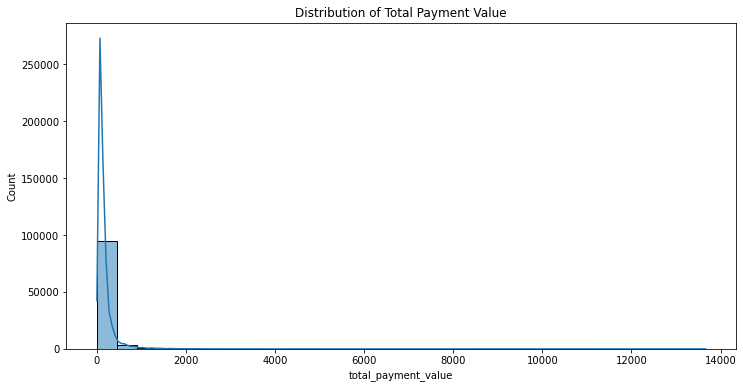

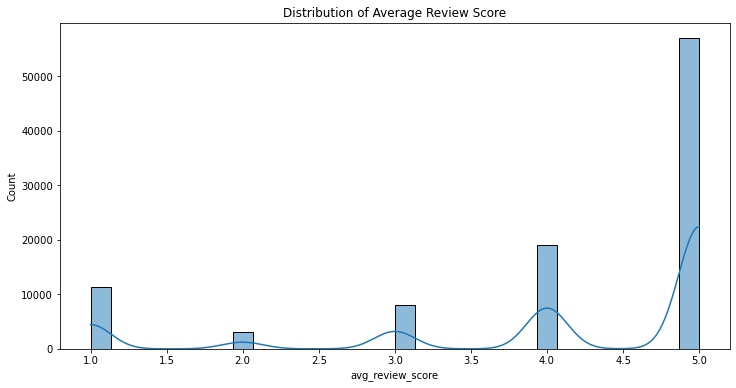

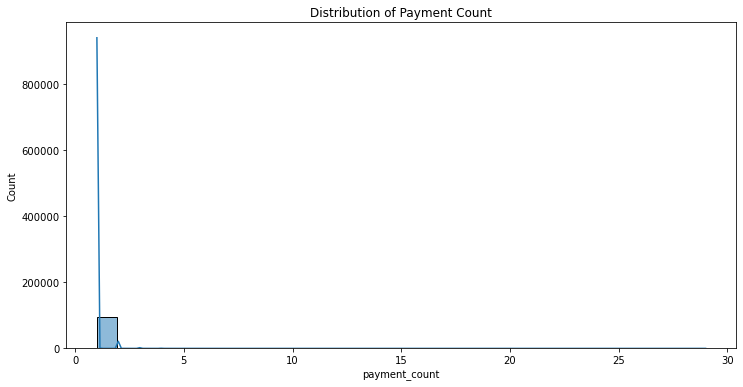

In [34]:
# Visualize distributions of key features
plt.figure(figsize=(12, 6))
sns.histplot(df_final['total_payment_value'], bins=30, kde=True)
plt.title('Distribution of Total Payment Value')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_final['avg_review_score'], bins=30, kde=True)
plt.title('Distribution of Average Review Score')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_final['payment_count'], bins=30, kde=True)
plt.title('Distribution of Payment Count')
plt.show()


Correlation matrix:
                          customer_zip_code_prefix  avg_review_score  \
customer_zip_code_prefix                  1.000000         -0.016327   
avg_review_score                         -0.016327          1.000000   
review_count                              0.001399         -0.003710   
total_payment_value                       0.057813         -0.049137   
payment_count                            -0.005991         -0.004567   

                          review_count  total_payment_value  payment_count  
customer_zip_code_prefix      0.001399             0.057813      -0.005991  
avg_review_score             -0.003710            -0.049137      -0.004567  
review_count                  1.000000            -0.009796       0.005426  
total_payment_value          -0.009796             1.000000       0.002036  
payment_count                 0.005426             0.002036       1.000000  


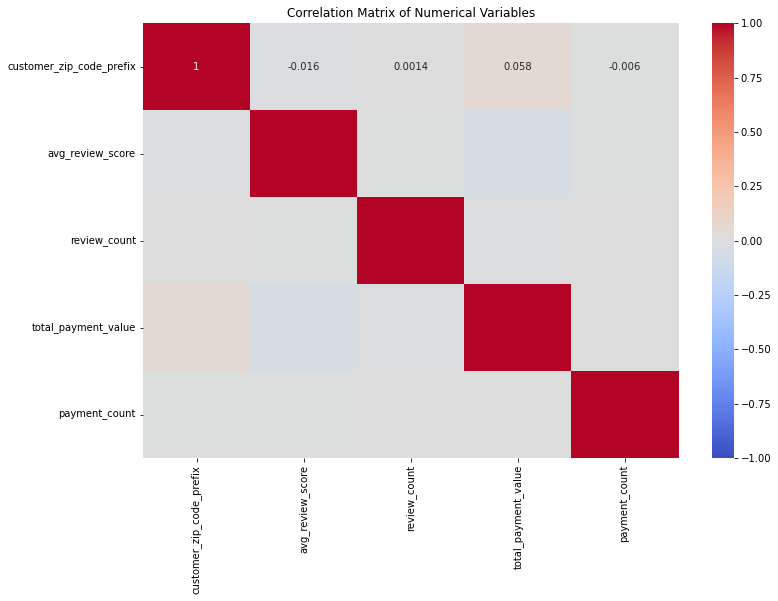

In [35]:
# Correlation matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the final DataFrame from the CSV file
df_final_path = os.path.join('..', 'data', 'df_final.csv')
df_final = pd.read_csv(df_final_path)

# Select the relevant numerical variables (excluding 'index_order' and 'index_customer')
numerical_vars = ['customer_zip_code_prefix', 'avg_review_score', 'review_count', 'total_payment_value', 'payment_count']

# Compute the correlation matrix
correlation_matrix = df_final[numerical_vars].corr()

# Print the correlation matrix
print("Correlation matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()



### Business Interpretation:

- Customer Location (Zip Code):
        Customer location, as indicated by zip code, does not have a significant impact on their behavior in terms of review scores, number of reviews, payment value, or payment count. This means marketing strategies and customer satisfaction efforts do not need to be heavily tailored based on customer location.

- Customer Reviews:
        The average review score and the number of reviews a customer leaves are largely independent of their payment behavior. This implies that a customer's satisfaction as reflected in reviews does not correlate strongly with how much they spend or how many payments they make.

- Customer Payments:
        The total payment value and the number of payments a customer makes are almost independent of their review scores and review count. This suggests that higher spending customers are not necessarily the ones who leave more or better reviews.

- Segmenting Customers:

    For segmentation purposes, it might be more beneficial to focus on variables other than those analyzed here, such as purchase frequency, recency of purchases, and specific product categories of interest to the customer. 
        

### Feature Engineering (RFM and Other Features)

In [36]:
import pandas as pd
import numpy as np
import os

# Load the final DataFrame
df_final_path = os.path.join('..', 'data', 'df_final.csv')
df_final = pd.read_csv(df_final_path)

# Convert date columns to datetime
df_final['order_purchase_timestamp'] = pd.to_datetime(df_final['order_purchase_timestamp'])

# Recency: Days since last purchase
max_purchase_date = df_final['order_purchase_timestamp'].max()
df_final['recency'] = (max_purchase_date - df_final['order_purchase_timestamp']).dt.days

# Frequency: Number of orders per customer
frequency = df_final.groupby('customer_unique_id').size().reset_index(name='frequency')

# Monetary: Total payment value per customer
monetary = df_final.groupby('customer_unique_id')['total_payment_value'].sum().reset_index()

# Merge RFM features into df_final
df_final = df_final.merge(frequency, on='customer_unique_id', how='left').merge(monetary, on='customer_unique_id', how='left')

# Handle missing values
df_final['recency'].fillna(0, inplace=True)
df_final['frequency'].fillna(0, inplace=True)
df_final['total_payment_value'].fillna(0, inplace=True)
df_final['avg_review_score'].fillna(0, inplace=True)
df_final['review_count'].fillna(0, inplace=True)

# Save the updated DataFrame to CSV
output_path = os.path.join('..', 'data', 'df_final_with_rfm.csv')
df_final.to_csv(output_path, index=False)
print(f"df_final saved to {output_path}")

# Check the structure and head of the final DataFrame
print("Final DataFrame structure and first few rows:")
print(df_final.info())
print(df_final.head())


KeyError: 'total_payment_value'